In [1]:
from mssa.mssa import mSSA
import pandas as pd 
import matplotlib.pyplot as plt 
import io
import numpy as np 
import torch 
import copy 
from sklearn.metrics import r2_score
import os 
dev = False

In [2]:
file = "LD2011_2014_clean.txt"
isExist = os.path.exists(file)
if not isExist:
    !wget https://archive.ics.uci.edu/ml/machine-learning-databases/00321/LD2011_2014.txt.zip
    !unzip LD2011_2014.txt.zip
    # change commas to dots
    !sed 's/,/./g' LD2011_2014.txt > LD2011_2014_clean.txt
else: 
    print(f"Files are ready")

Files are ready


In [ ]:
"""Preprocess data"""
data = pd.read_csv('LD2011_2014_clean.txt', delimiter = ';')
#remove data before 2012
data = data.iloc[8760*4:]
print('Data loaded..')
data_2 = data.copy()
#pick the first 20 houses
data_2 = data_2.iloc[:,:]
# Aggregate
data_2['time'] =pd.to_datetime(data_2['Unnamed: 0']).dt.ceil('1h') 
data_2 = data_2.drop(['Unnamed: 0'], axis = 1)
agg_dict = {}
for col in data_2.columns[:-1]:
    agg_dict[col] ='mean'
aggregated_data = data_2.groupby(['time']).agg(agg_dict)
print('Data aggregated by hour')
aggregated_data.shape

In [ ]:
aggregated_data.shape

(26304, 370)

In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
Std_normalization = 1
if Std_normalization:
    scaler = StandardScaler()
    temp = scaler.fit_transform(aggregated_data)
    norm_means = scaler.mean_
    norm_std = scaler.scale_
else:
    scaler = MinMaxScaler()
    temp = scaler.fit_transform(aggregated_data)
global data_4
normalized_data = pd.DataFrame(temp, index=aggregated_data.index, columns = aggregated_data.columns)

In [ ]:
normalized_data.head()

,MT_001,MT_002,MT_003,MT_004,MT_005,MT_006,MT_007,MT_008,MT_009,MT_010,...,MT_361,MT_362,MT_363,MT_364,MT_365,MT_366,MT_367,MT_368,MT_369,MT_370
time,,,,,,,,,,,,,,,,,,,,,
2012-01-01 01:00:00,-0.193637,-0.767048,5.979015,0.750556,1.297119,2.562526,0.380006,0.420689,0.936652,1.237010,...,-0.925467,-0.660711,-0.611351,-0.924599,-1.182866,0.055241,-0.298429,-0.970811,-0.867907,-1.312616
2012-01-01 02:00:00,-0.088516,-0.711666,5.979015,0.723940,1.174705,2.419487,0.131533,0.362440,0.666522,1.016322,...,-0.968145,-0.718147,-0.862776,-0.926923,-1.177477,-0.195217,-0.111780,-0.964607,-0.923605,-1.312616
2012-01-01 03:00:00,-0.193637,-0.739357,5.979015,0.710631,0.964851,1.573172,0.090121,-0.263732,0.500288,0.616982,...,-1.023433,-0.710625,-0.879452,-0.931572,-1.177477,-0.289139,-0.478750,-1.119708,-1.044284,-1.312616
2012-01-01 04:00:00,-0.088516,-0.877811,5.979015,-0.194342,0.037999,0.059340,-0.179057,-0.948152,-0.559453,-0.391876,...,-1.228097,-0.732505,-0.896128,-0.957141,-1.139759,-0.289139,-1.696712,-1.175544,-1.102634,-1.312616
2012-01-01 05:00:00,-0.141076,-0.905502,5.979015,-0.726679,-0.259294,-0.524736,-0.365412,-1.297643,-0.351661,-0.539002,...,-1.179598,-0.753702,-0.901901,-0.961790,-1.182866,-0.383061,-1.707784,-1.169340,-1.072133,-1.312616


In [ ]:
if dev:
    cols = normalized_data.columns

In [ ]:
if dev:
    test_df = normalized_data.iloc[:5][cols[:5]].copy()
    np_test = test_df.to_numpy()

In [ ]:
if dev:
    """Inject missing data"""
    # Convert original data to 1d array - Because existing package only supports randomly choose from 1d array
    np_test_1d = np_test.flatten()
    np_test_1d

In [ ]:
if dev:
    total_elem = np_test_1d.shape[0]
    missing_percentage = 50
    number_of_missing_elem = int(missing_percentage*1.0*total_elem/100) 
    print(number_of_missing_elem)
    missing_index = np.random.choice(np.arange(total_elem), number_of_missing_elem, replace=False)
    np_test_1d[missing_index] = 0
    np_test_1d

In [ ]:
if dev:
    np_test_2d = np_test_1d.reshape(5,-1)
    np_test_2d

In [ ]:
"""

Create missing values based on normal distribution random choice

Input: 
 - pd_data: 2d pandas data frame
 - missing_percentage: missing percentage <= 100

Output:
 - return_data: 2d pandas with missed values

"""
def create_missing_data(pd_data, missing_percentage = 20):
    assert missing_percentage <= 100, "missing percentage should be less than or equal 100%"
    np.random.seed(1993)
    # Convert data frame to array
    np_data = pd_data.to_numpy()
    # Convert original data to 1d array - Because existing package only supports randomly choose from 1d array
    np_data_1d = np_data.flatten()
    # Randomly choose missing index
    total_elem = np_data_1d.shape[0]
    number_of_missing_elem = int(missing_percentage*1.0*total_elem/100)
    missing_index = np.random.choice(np.arange(total_elem), number_of_missing_elem, replace=False) # with replace = False, an index only is chosen 1 time
    # Replace missing_index with 0
    np_data_1d[missing_index] = 0
    # Convert 1d array to 2d array
    np_data_2d = np_data_1d.reshape(pd_data.shape[0], pd_data.shape[1])
    # Convert 2d array to dataframe
    cols_name = pd_data.columns
    return_data = pd.DataFrame(np_data_2d, columns = cols_name)
    return_data.index = pd_data.index
    return return_data

missing_df = create_missing_data(normalized_data, missing_percentage=20)
missing_df.head()

,MT_001,MT_002,MT_003,MT_004,MT_005,MT_006,MT_007,MT_008,MT_009,MT_010,...,MT_361,MT_362,MT_363,MT_364,MT_365,MT_366,MT_367,MT_368,MT_369,MT_370
time,,,,,,,,,,,,,,,,,,,,,
2012-01-01 01:00:00,-0.193637,0.000000,0.000000,0.750556,1.297119,2.562526,0.380006,0.420689,0.936652,1.237010,...,0.000000,-0.660711,-0.611351,-0.924599,-1.182866,0.000000,-0.298429,0.000000,-0.867907,-1.312616
2012-01-01 02:00:00,-0.088516,-0.711666,5.979015,0.723940,0.000000,0.000000,0.131533,0.362440,0.000000,1.016322,...,0.000000,-0.718147,-0.862776,-0.926923,-1.177477,-0.195217,-0.111780,-0.964607,-0.923605,-1.312616
2012-01-01 03:00:00,-0.193637,-0.739357,0.000000,0.710631,0.000000,0.000000,0.090121,-0.263732,0.500288,0.616982,...,-1.023433,-0.710625,-0.879452,-0.931572,-1.177477,0.000000,0.000000,-1.119708,-1.044284,0.000000
2012-01-01 04:00:00,0.000000,-0.877811,5.979015,-0.194342,0.037999,0.059340,-0.179057,-0.948152,0.000000,-0.391876,...,-1.228097,-0.732505,-0.896128,-0.957141,0.000000,-0.289139,0.000000,-1.175544,0.000000,-1.312616
2012-01-01 05:00:00,0.000000,-0.905502,5.979015,-0.726679,-0.259294,0.000000,-0.365412,-1.297643,-0.351661,-0.539002,...,-1.179598,-0.753702,-0.901901,0.000000,-1.182866,0.000000,-1.707784,-1.169340,0.000000,-1.312616


In [ ]:
global n_clients; global data_train; global data_test
def set_train_test(n_clients=20):
    data_train = normalized_data.iloc[:25968,:n_clients] #25600; 25968; 26082
    data_test = normalized_data.iloc[25968:,:n_clients]
    return data_train, data_test

In [ ]:
data_train, data_test = set_train_test(n_clients=370)
data_train.shape

(25968, 370)

In [ ]:
def get_flattened_obs(data_train, L=80):
    df = data_train
    N = df.shape[1]
    col_to_row_ratio = 4

    T = df.shape[0]

    M = int(df.size / L)
    if M%N != 0:
        M -= M%N
    M_ts = M // N
    # inc_obs = np.array(df.iloc[:M_ts*L,:]) # first range, we use second range for traning
    inc_obs = np.array(df.iloc[T%L:,:]) # second range, note its not T%L+1 due to python index
    normalize = False
    from sklearn.preprocessing import StandardScaler
    if normalize:
        scaler = StandardScaler()
        inc_obs = scaler.fit_transform(inc_obs)
        norm_means = scaler.mean_
        norm_std = scaler.scale_

    flattened_obs = inc_obs.reshape([L,M], order = 'F') # 按照列顺序
    # flattened_obs = flattened_obs[:,np.arange(M_ts*self.no_ts).reshape([self.no_ts,M_ts]).flatten('F')] # 这里导致第二列是ts2，stacked page是不同ts交错组成
    return flattened_obs, M_ts

In [ ]:
global N; global M_ts; global L; global window
L = 80
flattened_obs, M_ts = get_flattened_obs(data_train, L=L)
window = M_ts

In [ ]:
def predict_one_day(data_test, model, weights):

    #initialise prediction array
    predictions = np.zeros((len(data_test.columns),24*7))
    ub = np.zeros((len(data_test.columns),24*7))
    lb = np.zeros((len(data_test.columns),24*7))

    # specify start time
    start_time = pd.Timestamp('2014-12-18 01:00:00')

    # actual = data_test.values[:24*7,:]

    # obtain new actual by index, new test start from 2014-12-02-17:00
    actual = data_test[data_test.index>=start_time].values[:24*7,:]

    # predict for seven days
    days = 7

    for day in range(days):
        # get the final time stamp in the day
        end_time = start_time + pd.Timedelta(hours=23)
        # convert timestamps to string
        start_str = start_time.strftime('%Y-%m-%d %H:%M:%S')
        end_str = end_time.strftime('%Y-%m-%d %H:%M:%S')
        # predict for each house
        for i, column in enumerate(data_test.columns):
            # Forecast
            df_30 = model.predict(column,start_str,end_str)
            predictions[i,day*24:(day+1)*24] = df_30['Mean Predictions']
            ub[i,day*24:(day+1)*24] = df_30['Upper Bound']
            lb[i,day*24:(day+1)*24] = df_30['Lower Bound']

        # fit the model with the already predicted values 

        # df_insert = data_test.iloc[day*24:24*(day+1),:]

        # obtain new df_insert
        # df_insert = data_test[data_test.index>=start_time].iloc[day*24:24*(day+1),:]

        # model.update_model(df_insert)
    
        if weights is not None:
            model.ts_model.models[0].weights = weights

        # update start_time
        start_time = start_time + pd.Timedelta(hours=24)
    return actual, predictions

In [ ]:
def test_sd(data_train, data_test, L, n_users, M_ts, dim, days, plot_all):
    flattened_obs, M_ts = get_flattened_obs(data_train, L=L)
    # stand-alone ssa
    global window;
    window = M_ts
    lst_U_sd = []
    for i in range(n_users):
        data = flattened_obs[:,i*window:(i+1)*window]
        U,_,_ = np.linalg.svd(data)
        U = U[:,:dim]
        lst_U_sd.append(U)
        
    model_sd = mSSA(rank = dim, normalize = False, L=L)
    model_sd.update_model(data_train)

    P_sd = flattened_obs
    P_sd_hat = []
    y_sd = []
    y_true = P_sd[-1,:]
    P_tilde_sd_hat = []
    imputation_model_score_sd = []
    
    for i in range(n_users):
        P_i_sd = P_sd[:,int(i*window):int((i+1)*window)]
        P_i_sd_hat = lst_U_sd[i].dot(lst_U_sd[i].T.dot(P_i_sd)); P_sd_hat.append(P_i_sd_hat)
        y_i_sd = P_i_sd_hat[-1,:]; y_sd.append(y_i_sd)
        y_i_true = P_i_sd[-1,:]
        P_i_tilde_sd_hat = P_i_sd_hat[:-1,:]; P_tilde_sd_hat.append(P_i_tilde_sd_hat)
        imputation_model_score_sd.append(r2_score(P_i_sd.flatten('F'),P_i_sd_hat.flatten('F'))) # verified same as imputation_model_score)
    imputation_model_score_sd = np.array(imputation_model_score_sd)
    P_sd_hat = np.hstack(P_sd_hat)
    y_sd = np.hstack(y_sd)
    P_tilde_sd_hat = np.hstack(P_tilde_sd_hat)
    print("imputation score:", imputation_model_score_sd.mean())

    # verify weights_admm using sklearn
    from sklearn.linear_model import LinearRegression
    reg = LinearRegression(fit_intercept=False).fit(P_tilde_sd_hat.T, y_sd)
    weights_sd = reg.coef_
    
    model_sd.ts_model.models[0].weights = weights_sd
    
    actual, predictions_sd = predict_one_day(data_test, model_sd, weights_sd)

    Y = actual[:,:]
    Y_h_sd = predictions_sd.T[:,:]
    mse_sd = np.sqrt(np.mean(np.square(Y[:7*days]-Y_h_sd[:7*days])))
    print ('Forecasting accuracy (RMSE) my:',mse_sd)
    
    if plot_all:
        npar = np.arange(0,20)
    else: npar = [1]
    for i in npar:
        plt.figure()
        plt.title('forecasting the next seven days for %s'%data_test.columns[i])
#         plt.plot(predictions[i,:24*days],label= 'mSSA',color='green')
#         plt.plot(predictions_my[i,:24*days],label= 'FedmSSA',color='orange')
        plt.plot(predictions_sd[i,:24*days],label= 'sd',color='pink')
        plt.plot(actual[:24*days,i],label = 'actual',color='blue')
        plt.legend()
    plt.show()
    
    return Y, Y_h_sd, weights_sd, lst_U_sd

In [ ]:
def test_mssa(data_train, data_test, rank, L, n_users, days, plot_all):
    data_train = data_train.iloc[:,:n_users]
    data_test = data_test.iloc[:,:n_users]
    model = mSSA(rank = rank, normalize = False, L=L)
    
    # model
    model.update_model(data_train)
    actual, predictions = predict_one_day(data_test, model, None)

    Y = actual[:,:]
    Y_h = predictions.T[:,:]
    mse = np.sqrt(np.mean(np.square(Y[:7*days]-Y_h[:7*days])))
    print ('Forecasting accuracy (RMSE):',mse)
    
    if plot_all:
        npar = np.arange(0,20)
    else: npar = [1]
    for i in npar:
        plt.figure()
        plt.title('forecasting the next seven days for %s'%data_test.columns[i])
        plt.plot(predictions[i,:24*days],label= 'mSSA',color='green')
        plt.plot(actual[:24*days,i],label = 'actual',color='blue')
        plt.legend()
    plt.show()
    
    return Y, Y_h, model.ts_model.models[0].weights

In [ ]:
def test_fedMssa(data_train, data_test, L, n_users, M_ts, dim, days, plot_all):

    flattened_obs, M_ts = get_flattened_obs(data_train, L=L)

    # model
    model_my = mSSA(rank = dim, normalize = False, L=L)
    # model
    model_my.update_model(data_train)

    P_admm = flattened_obs
    results_path = f"../SSA/"
    file_name = f"Grassmann_ADMM_Elec{n_users}_missingVal_N{n_users}_L80_d80_rhoauto_imputation.npy"
    file_path = os.path.join(results_path, file_name)
    Uk_admm = np.load(file_path)
    
    
    # Select PCs by Sigma
    lst_U = []
    for i in range(n_users):
        proj_admm_i = Uk_admm.T.dot(P_admm[:,i*M_ts:(i+1)*M_ts])
        S2_admm_i_est = proj_admm_i.dot(proj_admm_i.T)
        S2_admm_i = np.diag(S2_admm_i_est)
        S_admm_i = np.sqrt(S2_admm_i)
        Uk_admm_i = Uk_admm[:,S_admm_i.argsort()[::-1][:dim]] # 针对每一个client，取Uk的那20列，which 取决于 S_admm的大小
        lst_U.append(Uk_admm_i)
    
    # Select PCs randomly
#     select_idx = np.random.choice(np.arange(L),dim,replace=False)
#     lst_U = []
#     for i in range(n_users):
#         lst_U.append(Uk_admm[:,:dim])
#     print("Uk shape: ", lst_U[0].shape)

    imputation_model_score_admm = []
    
    P_admm_hat = []
    y_admm = []
    y_true = P_admm[-1,:]
    P_tilde_admm_hat = []
    window = M_ts
    for i in range(n_users):
        P_i_admm = P_admm[:,int(i*window):int((i+1)*window)]
        P_i_admm_hat = lst_U[i].dot(lst_U[i].T.dot(P_i_admm)); P_admm_hat.append(P_i_admm_hat)
        y_i_admm = P_i_admm_hat[-1,:]; y_admm.append(y_i_admm)
        y_i_true = P_i_admm[-1,:]
        P_i_tilde_admm_hat = P_i_admm_hat[:-1,:]; P_tilde_admm_hat.append(P_i_tilde_admm_hat)
        imputation_model_score_admm.append(r2_score(P_i_admm.flatten('F'),P_i_admm_hat.flatten('F'))) # verified same as imputation_model_score)
    imputation_model_score_admm = np.array(imputation_model_score_admm)
    P_admm_hat = np.hstack(P_admm_hat)
    y_admm = np.hstack(y_admm)
    P_tilde_admm_hat = np.hstack(P_tilde_admm_hat)

    print("imputation score", imputation_model_score_admm.mean())

    # verify weights_admm using sklearn
    from sklearn.linear_model import LinearRegression
    reg = LinearRegression(fit_intercept=False).fit(P_tilde_admm_hat.T, y_admm)
    weights_LR = reg.coef_
    
    model_my.ts_model.models[0].weights = weights_LR
    
    actual, predictions_my = predict_one_day(data_test, model_my, weights_LR)

    Y = actual[:,:]
    Y_h_my = predictions_my.T[:,:]
    mse_my = np.sqrt(np.mean(np.square(Y[:7*days]-Y_h_my[:7*days])))
    print ('Forecasting accuracy (RMSE) my:',mse_my)
    
    if plot_all:
        npar = np.arange(0,25)
    else: npar = [1]
    for i in npar:
        plt.figure()
        plt.title('forecasting the next seven days for %s'%data_test.columns[i])
#         plt.plot(predictions[i,:24*7],label= 'mSSA',color='green')
        plt.plot(predictions_my[i,:24*days],label= 'FedmSSA',color='orange')
    #     plt.plot(predictions_sd[i,:24*7],label= 'sd',color='pink')
    #     plt.fill_between(np.arange(24*7), lb[i,:24*7], ub[i,:24*7], alpha = 0.1)
        plt.plot(actual[:24*days,i],label = 'actual',color='blue')
        plt.legend()
    plt.show()
    
    return Y, Y_h_my, weights_LR, lst_U

In [ ]:
data_train_missing_vals = create_missing_data(data_train, missing_percentage=20)
data_train_missing_vals.shape

(25968, 370)

In [ ]:
data_train_missing_vals.head()

,MT_001,MT_002,MT_003,MT_004,MT_005,MT_006,MT_007,MT_008,MT_009,MT_010,...,MT_361,MT_362,MT_363,MT_364,MT_365,MT_366,MT_367,MT_368,MT_369,MT_370
time,,,,,,,,,,,,,,,,,,,,,
2012-01-01 01:00:00,-0.193637,0.000000,0.000000,0.750556,1.297119,2.562526,0.380006,0.000000,0.936652,1.237010,...,0.000000,-0.660711,-0.611351,-0.924599,-1.182866,0.000000,-0.298429,0.000000,-0.867907,-1.312616
2012-01-01 02:00:00,-0.088516,-0.711666,5.979015,0.723940,0.000000,0.000000,0.131533,0.362440,0.000000,1.016322,...,0.000000,-0.718147,-0.862776,-0.926923,-1.177477,-0.195217,-0.111780,-0.964607,-0.923605,-1.312616
2012-01-01 03:00:00,-0.193637,-0.739357,0.000000,0.710631,0.000000,0.000000,0.090121,-0.263732,0.500288,0.616982,...,-1.023433,-0.710625,-0.879452,-0.931572,-1.177477,0.000000,0.000000,-1.119708,-1.044284,0.000000
2012-01-01 04:00:00,0.000000,-0.877811,5.979015,-0.194342,0.037999,0.059340,-0.179057,-0.948152,0.000000,-0.391876,...,-1.228097,-0.732505,-0.896128,-0.957141,-1.139759,-0.289139,0.000000,-1.175544,0.000000,-1.312616
2012-01-01 05:00:00,0.000000,-0.905502,5.979015,-0.726679,-0.259294,-0.524736,-0.365412,-1.297643,-0.351661,-0.539002,...,-1.179598,-0.753702,-0.901901,0.000000,-1.182866,0.000000,-1.707784,-1.169340,0.000000,-1.312616


In [ ]:
create_csv_data = False

In [ ]:
if create_csv_data:
    for i in range(data_train_missing_vals.shape[1]):
        data_train_missing_vals.iloc[:,i].to_csv('../../data/electricity_train_missing_20/'+ 'MT_{0:03}'.format(i+1) + '.csv')

# Run Test for 20 users, each user contain a time series data:

Setting:
- 20 users
- each global training round select 10% of users
- 20% missing values
- each user has a time series data with missing values

(25968, 370)
imputation score: 0.7831541459100999
Forecasting accuracy (RMSE) my: 0.6839287352633202


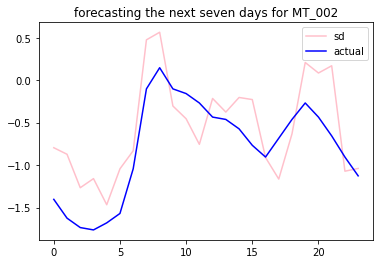

In [ ]:
for dim in [1]:
    Y1, Y_sd, weights_sd, lst_U_sd = test_sd(data_train_missing_vals, data_test, L=80, n_users=20, M_ts=window, dim=10, days=1, plot_all=False)

(25968, 20)
Forecasting accuracy (RMSE): 0.4718259765773435


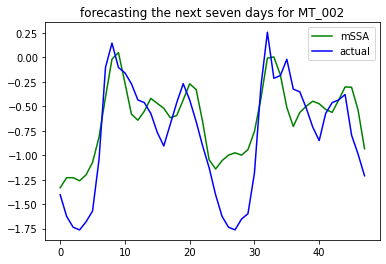

In [ ]:
for rank in [15]:
    Y2, Y_mssa, weights_mssa = test_mssa(data_train_missing_vals, data_test, rank=18, L=80, n_users=20, days=2, plot_all=False)

(25968, 370)
imputation score 0.9880753777441178
Forecasting accuracy (RMSE) my: 0.44859364625865517


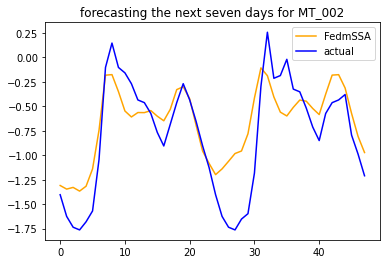

In [ ]:
Y3, Y_my, weights_my, lst_U_my = test_fedMssa(data_train, data_test, L=80, n_users=20, M_ts=window, dim=75, days=2, plot_all=False)

# Run Test for 370 users, each user contain a time series data:

Setting:
- 370 users
- each global training round select 10% of users
- 20% missing values
- each user has a time series data with missing values

(25968, 370)
imputation score: 0.804376197763135
Forecasting accuracy (RMSE) my: 0.4437141805565519


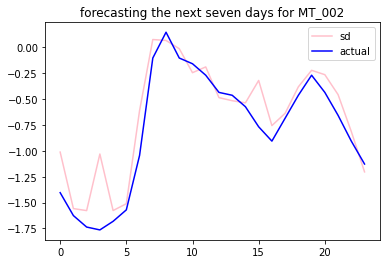

In [ ]:
for dim in [1]:
    Y1, Y_sd, weights_sd, lst_U_sd = test_sd(data_train_missing_vals, data_test, L=80, n_users=370, M_ts=window, dim=10, days=1, plot_all=False)

(25968, 370)
Forecasting accuracy (RMSE): 0.4135976120068264


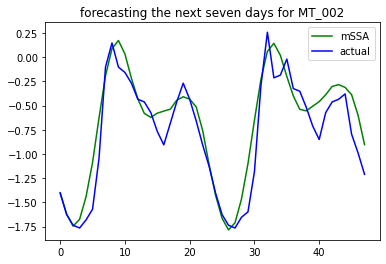

In [ ]:
for rank in [15]:
    Y2, Y_mssa, weights_mssa = test_mssa(data_train_missing_vals, data_test, rank=10, L=80, n_users=370, days=2, plot_all=False)

(25968, 370)
imputation score 0.9892051964184772
Forecasting accuracy (RMSE) my: 0.3805565170707597


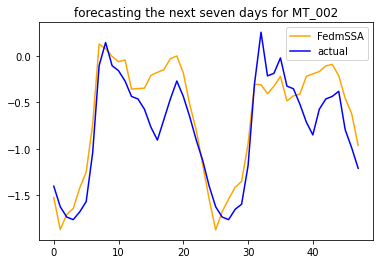

In [ ]:
Y3, Y_my, weights_my, lst_U_my = test_fedMssa(data_train, data_test, L=80, n_users=370, M_ts=window, dim=74, days=2, plot_all=False)